In [3]:
###################################################################################################
# https://www.hackerrank.com/contests/gs-codesprint-2018/challenges/car-popularity-prediction
shhh <- suppressPackageStartupMessages
# This code was written in base R as much as possible to be run on an external computer with a few exceptions.

library(xgboost) # for the XGBoost model
shhh(library(dplyr)) # for magrittr pipe functionality and dplyr mutatue functionality
library(caret) # for confusionMatrix
###################################################################################################

In [6]:
###################################################################################################
train_inSample <- read.csv("C:/Users/Matt/Desktop/Competitions/CarPopularity/train.csv")
test_outSample <- read.csv("C:/Users/Matt/Desktop/Competitions/CarPopularity/test.csv")

cols <- colnames(train_inSample)[-7]
colnames(test_outSample) <- colnames(train_inSample[cols])

head(train_inSample)
head(test_outSample)
###################################################################################################

buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating,popularity
3,2,4,2,2,2,1
3,2,2,5,2,1,1
1,4,2,5,1,3,1
4,4,2,2,1,2,1
3,3,3,4,3,3,2
2,1,2,2,1,1,1


buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating
4,1,2,2,2,2
2,1,3,4,3,2
4,4,2,5,1,2
4,3,3,2,2,2
4,2,2,4,3,2
4,3,5,2,3,3


In [10]:
###################################################################################################
################### Split the training data into 75% train and 25% validation #########################
set.seed(123)
train_validation_split = 0.75
smp_size <- floor(train_validation_split * nrow(train_inSample))
train_ind <- sample(seq_len(nrow(train_inSample)), size = smp_size)

train <- train_inSample[train_ind, ]
val <- train_inSample[-train_ind, ]

head(train)
head(val)
###################################################################################################

,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating,popularity
415,4,3,2,4,1,2,1
463,1,3,5,5,1,3,2
179,1,2,3,2,2,3,1
526,2,3,2,5,1,2,1
195,1,2,2,5,1,3,1
938,1,1,3,4,1,2,2


,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating,popularity
3,1,4,2,5,1,3,1
7,1,3,5,2,2,2,1
14,1,2,2,5,2,3,3
15,2,4,2,2,3,1,1
22,4,4,4,2,1,1,1
23,3,1,2,5,1,1,1


In [11]:
###################################################################################################
############ Split between x preditors and y prediction ############
x_train <- train[, 1:6]
x_val <- val[, 1:6] 

y_train <- train[, 7] - 1 # We -1 here since XGBoost can only take on labels in [0, num_class)
y_val <- val[, 7] - 1

head(x_train, 2)
head(x_val, 2)
head(y_train, 2)
head(y_val, 2)
###################################################################################################

,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating
415,4,3,2,4,1,2
463,1,3,5,5,1,3


,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating
3,1,4,2,5,1,3
7,1,3,5,2,2,2


[1] 0 1

[1] 0 0

In [15]:
###################################################################################################
# XGBoost xgb.DMatrix

dtrain <- xgb.DMatrix(data = as.matrix(x_train), label = y_train, missing = "NaN")
dval <- xgb.DMatrix(data = as.matrix(x_val), label = y_val, missing = "NaN")

print(dtrain)
print(dval)
###################################################################################################

xgb.DMatrix  dim: 1221 x 6  info: label  colnames: yes
xgb.DMatrix  dim: 407 x 6  info: label  colnames: yes


In [19]:
###################################################################################################
# Grid Search Parameters (very simplistic model for this test - I omit many of the XGBoost parameters due to time constraints):
# 1)
ParameterGridSearch <- expand.grid(max_depth = c(5, 8, 14), #Range (0, inf], default = 6
                                eta = c(0.1, 0.05, 0.3) #Range (0,1], default = 0.3
                                )


ntrees = 2
nrounds = 1500
early_stopping_rounds = 10
numberOfClasses = as.numeric(length(unique(y_train)))

# Search over a grid space to locate the most optimal parameters.
# 2)
system.time(
  Hyperparameters <- apply(ParameterGridSearch, 1, function(parameterList){
    MaxDepth = parameterList[["max_depth"]]
    EtaValue = parameterList[["eta"]]
    
    xgb_params <- list("objective" = "multi:softprob", # multi probabilistic classification
                       "eval_metric" = "mlogloss",
                       "num_class" = numberOfClasses,
                       "max_depth" = MaxDepth,
                       "eta" = EtaValue)
    
    xgboostModelCV <- xgb.cv(params = xgb_params,
                             data =  dtrain,
                             nfold = ntrees,
                             nrounds = nrounds,
                             early_stopping_rounds = early_stopping_rounds,
                             seed = 1234,
                             prediction = TRUE,
                             print_every_n = 500) # To save on output space in the ipynb file
    
    CrossValidationResults <<- as.data.frame(xgboostModelCV$evaluation_log)
    BestIteration = tail(CrossValidationResults, 1)
    EvaluationResults = return(c(BestIteration, MaxDepth, EtaValue))
    }
  )
)

CVResults <- as.data.frame(do.call(rbind, Hyperparameters))

# Find the best iteration by test_mlogloss and train_mlogloss
names(CVResults)[names(CVResults) == 'V6'] <- 'MaxDepth'
names(CVResults)[names(CVResults) == 'V7'] <- 'EtaValue'
print("The best parameters are:")
CVResults[with(CVResults, order("test_mlogloss_mean", "train_mlogloss_mean")), ]

print("The other parameters are:")
head(CVResults)
###################################################################################################

[1]	train-mlogloss:1.231559+0.001356	test-mlogloss:1.233828+0.000110 
Multiple eval metrics are present. Will use test_mlogloss for early stopping.
Will train until test_mlogloss hasn't improved in 10 rounds.

Stopping. Best iteration:
[184]	train-mlogloss:0.019723+0.000368	test-mlogloss:0.080088+0.009298

[1]	train-mlogloss:1.217302+0.001345	test-mlogloss:1.225348+0.000931 
Multiple eval metrics are present. Will use test_mlogloss for early stopping.
Will train until test_mlogloss hasn't improved in 10 rounds.

Stopping. Best iteration:
[112]	train-mlogloss:0.019388+0.001568	test-mlogloss:0.104205+0.012344

[1]	train-mlogloss:1.216668+0.001290	test-mlogloss:1.221100+0.000891 
Multiple eval metrics are present. Will use test_mlogloss for early stopping.
Will train until test_mlogloss hasn't improved in 10 rounds.

Stopping. Best iteration:
[253]	train-mlogloss:0.012736+0.000786	test-mlogloss:0.067186+0.008384

[1]	train-mlogloss:1.307780+0.002342	test-mlogloss:1.311593+0.000746 
Multip

   user  system elapsed 
  52.11   31.08   43.05 

[1] "The best parameters are:"


iter,train_mlogloss_mean,train_mlogloss_std,test_mlogloss_mean,test_mlogloss_std,MaxDepth,EtaValue
194,0.0189685,0.0004235,0.080148,0.00954,5,0.1


[1] "The other parameters are:"


iter,train_mlogloss_mean,train_mlogloss_std,test_mlogloss_mean,test_mlogloss_std,MaxDepth,EtaValue
194,0.0189685,0.0004235,0.080148,0.00954,5,0.1
122,0.018407,0.001464,0.104895,0.01255,8,0.1
263,0.0125325,0.0007685,0.0672465,0.0082325,14,0.1
354,0.021161,0.002279,0.1007005,0.0346275,5,0.05
297,0.0164475,0.0003705,0.097382,0.014646,8,0.05
261,0.0181415,0.0008235,0.085277,0.001917,14,0.05


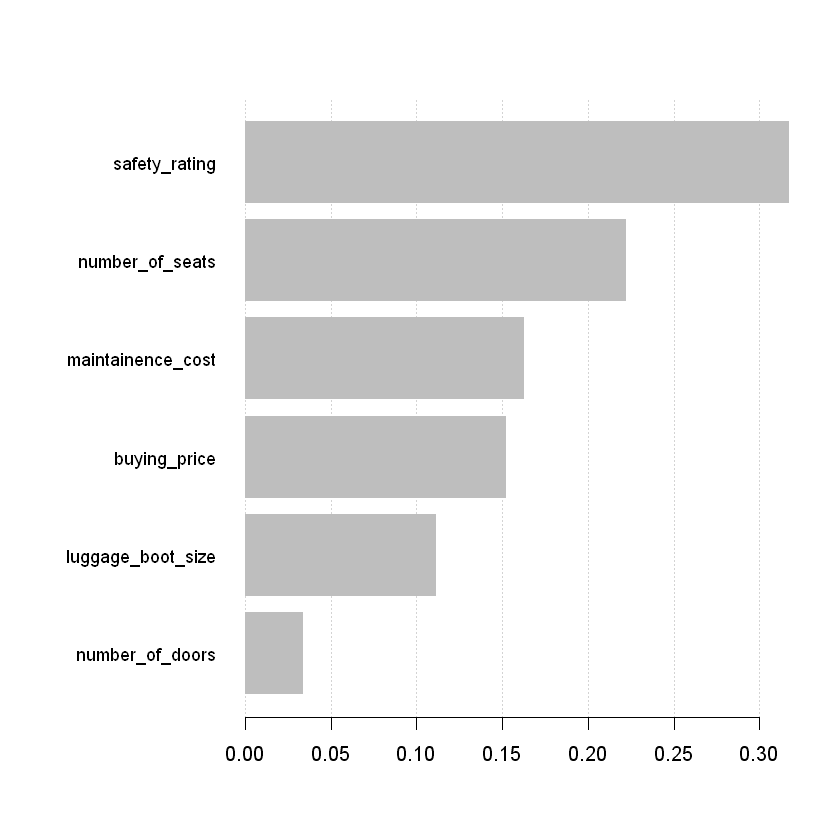

In [20]:
###################################################################################################
# Train the model using the optimal parameters from cross validation and calculate the in-sample confusionMatrix

Optimalparams <- list("eta" = head(CVResults$EtaValue, 1)[[1]], 
               "max_depth" = head(CVResults$MaxDepth, 1)[[1]], 
               "objective" = "multi:softprob",
               "eval_metric" = "mlogloss",
               "num_class" = numberOfClasses)

Optimalnround <- head(CVResults$iter, 1)[[1]]

# Train the final XGBoost model
xgb.model <- xgb.train(Optimalparams, dtrain, Optimalnround)

xgb.imp <- xgb.importance(model = xgb.model)
xgb.plot.importance(xgb.imp)
###################################################################################################

In [21]:
###################################################################################################
################## In-sample validation data predictions ##################
xgb.pred.val <- predict(xgb.model, newdata = dval) # Note we train the optimal parameters on this data

valConfMat <- matrix(xgb.pred.val, nrow = numberOfClasses,
                          ncol = length(xgb.pred.val) / numberOfClasses) %>%
  t() %>%
  data.frame() %>%
  mutate(label = y_val + 1,   # NOTE: We add the one back that we took away from earlier to the Y variable
         val_predictions = max.col(., "last"))

################## In-sample validation data confusion matrix ##################
confusionMatrix(factor(valConfMat$val_predictions),
                factor(valConfMat$label),
                mode = "everything")

# Approx 97% accuracy
###################################################################################################

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4
         1 290   0   0   0
         2   6  84   0   0
         3   0   1  13   0
         4   0   2   2   9

Overall Statistics
                                          
               Accuracy : 0.973           
                 95% CI : (0.9522, 0.9864)
    No Information Rate : 0.7273          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9375          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9797   0.9655  0.86667  1.00000
Specificity            1.0000   0.9812  0.99745  0.98995
Pos Pred Value         1.0000   0.9333  0.92857  0.69231
Neg Pred Value         0.9487   0.9905  0.99491  1.00000
Precision              1.0000   0.9333  0.92857  0.69231
Recall                 0.9797   0.9655  

In [22]:
###################################################################################################
# Make final predictions on the held out test set
dtest <- xgb.DMatrix(data = as.matrix(test_outSample), missing = "NaN")
xgb.pred.test <- predict(xgb.model, newdata = dtest)

test_predictions <- matrix(xgb.pred.test, nrow = numberOfClasses,
                     ncol = length(xgb.pred.test) / numberOfClasses) %>%
  t() %>%
  data.frame() %>%
  mutate(predictions = max.col(., "last")) %>%
  pull(predictions)
###################################################################################################

In [23]:
###################################################################################################
setwd("C:/Users/Matt/Desktop/Competitions/CarPopularity/")
write.csv(test_predictions, "prediction.csv")
###################################################################################################